In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential
from PIL import Image

import matplotlib.pyplot as plt
import glob

from copy import deepcopy
from sklearn.utils import shuffle

In [2]:
L = []
for img_path in glob.glob("data/*.png"):
    img = Image.open(img_path).convert("RGB")
    pixels = np.array(img).astype(np.float32)/255
    L.append(pixels)
pixels = np.array(L)
data = shuffle(deepcopy(pixels))
print(data.shape)

(21551, 64, 64, 3)


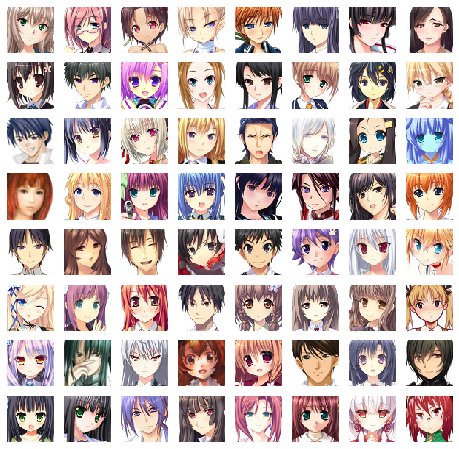

In [3]:
_,ax = plt.subplots(8,8, figsize = (8,8)) 
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(data[8*i+j])
        ax[i,j].axis('off')

In [4]:
training, testing = data[:15086], data[15086:]

In [6]:
print(training.shape)
print(testing.shape)

(15086, 64, 64, 3)
(6465, 64, 64, 3)


In [7]:
class VAE(Model):
    def __init__(self, latent_dim = 50):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference = Sequential(
            [
                layers.InputLayer(input_shape = (64, 64, 3)),
                layers.Conv2D(filters = 32, kernel_size = 3, strides = (2, 2), activation = "relu"),
                layers.Conv2D(filters = 64, kernel_size = 3, strides = (2, 2), activation = "relu"),
                layers.Flatten(),
                layers.Dense(latent_dim)
            ]
        )
        self.generative = Sequential(
            [
                layers.InputLayer(input_shape = latent_dim),
                layers.Dense(units = 16*16*32, activation = "relu"),
                layers.Reshape(target_shape = (16, 16, 32)),
                layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = (2,2), padding = "SAME", activation = "relu"),
                layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = (2,2), padding = "SAME", activation = "relu"),
                layers.Conv2DTranspose(filters = 3, kernel_size = 3, strides = (1,1), padding = "SAME")
            ]
        )

In [13]:
class VAETrain(VAE):
    def __init__(self, X, epochs, batch_size):
        super(VAETrain, self).__init__()
        self.X = X
        self.epochs = epochs
        self.batch_size = batch_size
    
    def train(self):
        optimizer = tf.optimizers.Adam(learning_rate = 0.001)
        for epoch in range(self.epochs):
            ind = np.random.permutation(range(len(self.X)))
            for i in range(0, len(self.X), self.batch_size):
                mini_batch_ind = ind[i : i+self.batch_size]
                X_mini_batch = self.X[mini_batch_ind]

                with tf.GradientTape() as tape:
                    output = self.call(X_mini_batch)
                    loss = self.computeLoss(output)
                parameters = self.trainable_variables
                grades = tape.gradient(loss, parameters)
                optimizer.apply_gradients(zip(grades, parameters))
                
            print("====Epoch:{}====".format(epoch+1), end='\r')
            if (epoch+1) % 10 == 0:
                print(loss)         
        
    def call(self, inputs):
        mean, var = self.encoding(inputs)
        z = self.reparameterize(mean, var)
        x = self.decoding(z, training = True)
        return x

    def encoding(self, inputs):
        mean, var = tf.split(self.inference(inputs), num_or_size_splits = 2, axis = 1)
        return mean, var

    def reparameterize(self, mean, var):
        err = tf.random.normal(shape = mean.shape)
        std = var**0.5
        return err * tf.exp(std) + mean

    def decoding(self, inputs, training = False):
        logits = self.generative(inputs)
        if training:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def computeLoss(self, x_logit, x, var, mean):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        cross_entropy = tf.reduce_sum(cross_entropy)/x.shape[0]
        kl_div = tf.reduce_sum(-0.5*(var+1-mean**2-tf.exp(var)))/x.shape[0]        
        return cross_entropy + 1.*kl_div



In [ ]:
test = VAETrain(training, epochs=20, batch_size=200)
test.train()